In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# Parameters
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [26]:
# Data Preparation
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 255).float() // (256 // PIXEL_LEVELS))
])
path= "./data"
dataset = datasets.FashionMNIST(root=path, train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [27]:
# Masked Convolution Layer
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', self.weight.data.clone())
        _, _, h, w = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, h // 2, w // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, h // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)


In [28]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(filters, filters // 2, kernel_size=1),
            nn.ReLU(),Votre
            MaskedConv2d('B', filters // 2, filters // 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(filters // 2, filters, kernel_size=1)
        )

    def forward(self, x):
        return x + self.block(x)


In [29]:
# PixelCNN Model
class PixelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            MaskedConv2d('A', 1, N_FILTERS, kernel_size=7, padding=3),
            *[ResidualBlock(N_FILTERS) for _ in range(RESIDUAL_BLOCKS)],
            nn.ReLU(),
            MaskedConv2d('B', N_FILTERS, N_FILTERS, kernel_size=1),
            nn.ReLU(),
            MaskedConv2d('B', N_FILTERS, N_FILTERS, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(N_FILTERS, PIXEL_LEVELS, kernel_size=1)
        )

    def forward(self, x):
        return self.model(x)

model = PixelCNN().to(DEVICE)


In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()
# Training Loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, _ in tqdm(data_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):

        images = images.to(DEVICE).squeeze(1)
        optimizer.zero_grad()
        inputs = images.float().unsqueeze(1)     # [batch, 1, H, W]
        targets = images.long()                  # [batch, H, W]
        outputs = model(inputs)                  # [batch, PIXEL_LEVELS, H, W]
        loss = criterion(outputs, targets)       # CrossEntropy expects float inputs and long targets
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1/150: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]


Epoch 1, Loss: 0.4316


Epoch 2/150: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Epoch 2, Loss: 0.3374


Epoch 3/150: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]


Epoch 3, Loss: 0.3276


Epoch 4/150: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]


Epoch 4, Loss: 0.3223


Epoch 5/150: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]


Epoch 5, Loss: 0.3183


Epoch 6/150: 100%|██████████| 469/469 [00:20<00:00, 23.12it/s]


Epoch 6, Loss: 0.3147


Epoch 7/150: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]


Epoch 7, Loss: 0.3125


Epoch 8/150: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]


Epoch 8, Loss: 0.3093


Epoch 9/150: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]


Epoch 9, Loss: 0.3071


Epoch 10/150: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]


Epoch 10, Loss: 0.3051


Epoch 11/150: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]


Epoch 11, Loss: 0.3032


Epoch 12/150: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]


Epoch 12, Loss: 0.3010


Epoch 13/150: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]


Epoch 13, Loss: 0.2994


Epoch 14/150: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]


Epoch 14, Loss: 0.2977


Epoch 15/150: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]


Epoch 15, Loss: 0.2960


Epoch 16/150: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]


Epoch 16, Loss: 0.2949


Epoch 17/150: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]


Epoch 17, Loss: 0.2935


Epoch 18/150: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]


Epoch 18, Loss: 0.2920


Epoch 19/150: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch 19, Loss: 0.2913


Epoch 20/150: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]


Epoch 20, Loss: 0.2901


Epoch 21/150: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]


Epoch 21, Loss: 0.2893


Epoch 22/150: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]


Epoch 22, Loss: 0.2885


Epoch 23/150: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]


Epoch 23, Loss: 0.2875


Epoch 24/150: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]


Epoch 24, Loss: 0.2868


Epoch 25/150: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Epoch 25, Loss: 0.2862


Epoch 26/150: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]


Epoch 26, Loss: 0.2853


Epoch 27/150: 100%|██████████| 469/469 [00:20<00:00, 23.12it/s]


Epoch 27, Loss: 0.2849


Epoch 28/150: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]


Epoch 28, Loss: 0.2844


Epoch 29/150: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]


Epoch 29, Loss: 0.2838


Epoch 30/150: 100%|██████████| 469/469 [00:20<00:00, 23.26it/s]


Epoch 30, Loss: 0.2831


Epoch 31/150: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]


Epoch 31, Loss: 0.2826


Epoch 32/150: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]


Epoch 32, Loss: 0.2823


Epoch 33/150: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]


Epoch 33, Loss: 0.2818


Epoch 34/150: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch 34, Loss: 0.2811


Epoch 35/150: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]


Epoch 35, Loss: 0.2808


Epoch 36/150: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]


Epoch 36, Loss: 0.2803


Epoch 37/150: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch 37, Loss: 0.2800


Epoch 38/150: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]


Epoch 38, Loss: 0.2798


Epoch 39/150: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]


Epoch 39, Loss: 0.2793


Epoch 40/150: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Epoch 40, Loss: 0.2789


Epoch 41/150: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]


Epoch 41, Loss: 0.2786


Epoch 42/150: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]


Epoch 42, Loss: 0.2783


Epoch 43/150: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]


Epoch 43, Loss: 0.2782


Epoch 44/150: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]


Epoch 44, Loss: 0.2775


Epoch 45/150: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]


Epoch 45, Loss: 0.2772


Epoch 46/150: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Epoch 46, Loss: 0.2769


Epoch 47/150: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]


Epoch 47, Loss: 0.2767


Epoch 48/150: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]


Epoch 48, Loss: 0.2763


Epoch 49/150: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]


Epoch 49, Loss: 0.2764


Epoch 50/150: 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]


Epoch 50, Loss: 0.2760


Epoch 51/150: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]


Epoch 51, Loss: 0.2757


Epoch 52/150: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]


Epoch 52, Loss: 0.2755


Epoch 53/150: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]


Epoch 53, Loss: 0.2752


Epoch 54/150: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]


Epoch 54, Loss: 0.2750


Epoch 55/150: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]


Epoch 55, Loss: 0.2747


Epoch 56/150: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]


Epoch 56, Loss: 0.2745


Epoch 57/150: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]


Epoch 57, Loss: 0.2743


Epoch 58/150: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]


Epoch 58, Loss: 0.2740


Epoch 59/150: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]


Epoch 59, Loss: 0.2740


Epoch 60/150: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]


Epoch 60, Loss: 0.2737


Epoch 61/150: 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]


Epoch 61, Loss: 0.2735


Epoch 62/150: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]


Epoch 62, Loss: 0.2733


Epoch 63/150: 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]


Epoch 63, Loss: 0.2731


Epoch 64/150: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]


Epoch 64, Loss: 0.2729


Epoch 65/150: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]


Epoch 65, Loss: 0.2729


Epoch 66/150: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch 66, Loss: 0.2727


Epoch 67/150: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]


Epoch 67, Loss: 0.2725


Epoch 68/150: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]


Epoch 68, Loss: 0.2722


Epoch 69/150: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]


Epoch 69, Loss: 0.2721


Epoch 70/150: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Epoch 70, Loss: 0.2719


Epoch 71/150: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]


Epoch 71, Loss: 0.2717


Epoch 72/150: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]


Epoch 72, Loss: 0.2715


Epoch 73/150: 100%|██████████| 469/469 [00:20<00:00, 23.12it/s]


Epoch 73, Loss: 0.2714


Epoch 74/150: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]


Epoch 74, Loss: 0.2714


Epoch 75/150: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]


Epoch 75, Loss: 0.2711


Epoch 76/150: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]


Epoch 76, Loss: 0.2710


Epoch 77/150: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]


Epoch 77, Loss: 0.2709


Epoch 78/150: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]


Epoch 78, Loss: 0.2708


Epoch 79/150: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]


Epoch 79, Loss: 0.2707


Epoch 80/150: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]


Epoch 80, Loss: 0.2703


Epoch 81/150: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]


Epoch 81, Loss: 0.2703


Epoch 82/150: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]


Epoch 82, Loss: 0.2702


Epoch 83/150: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Epoch 83, Loss: 0.2701


Epoch 84/150: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]


Epoch 84, Loss: 0.2699


Epoch 85/150: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]


Epoch 85, Loss: 0.2697


Epoch 86/150: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]


Epoch 86, Loss: 0.2696


Epoch 87/150: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]


Epoch 87, Loss: 0.2696


Epoch 88/150: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]


Epoch 88, Loss: 0.2695


Epoch 89/150: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]


Epoch 89, Loss: 0.2693


Epoch 90/150: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]


Epoch 90, Loss: 0.2694


Epoch 91/150: 100%|██████████| 469/469 [00:20<00:00, 23.38it/s]


Epoch 91, Loss: 0.2690


Epoch 92/150: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Epoch 92, Loss: 0.2690


Epoch 93/150: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]


Epoch 93, Loss: 0.2688


Epoch 94/150: 100%|██████████| 469/469 [00:20<00:00, 23.26it/s]


Epoch 94, Loss: 0.2687


Epoch 95/150: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]


Epoch 95, Loss: 0.2685


Epoch 96/150: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]


Epoch 96, Loss: 0.2685


Epoch 97/150: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]


Epoch 97, Loss: 0.2685


Epoch 98/150: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]


Epoch 98, Loss: 0.2685


Epoch 99/150: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]


Epoch 99, Loss: 0.2682


Epoch 100/150: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]


Epoch 100, Loss: 0.2680


Epoch 101/150: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Epoch 101, Loss: 0.2681


Epoch 102/150: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch 102, Loss: 0.2679


Epoch 103/150: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]


Epoch 103, Loss: 0.2680


Epoch 104/150: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch 104, Loss: 0.2676


Epoch 105/150: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]


Epoch 105, Loss: 0.2676


Epoch 106/150: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]


Epoch 106, Loss: 0.2676


Epoch 107/150: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]


Epoch 107, Loss: 0.2675


Epoch 108/150: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch 108, Loss: 0.2674


Epoch 109/150: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]


Epoch 109, Loss: 0.2673


Epoch 110/150: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]


Epoch 110, Loss: 0.2673


Epoch 111/150: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]


Epoch 111, Loss: 0.2670


Epoch 112/150: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch 112, Loss: 0.2670


Epoch 113/150: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch 113, Loss: 0.2669


Epoch 114/150: 100%|██████████| 469/469 [00:20<00:00, 23.26it/s]


Epoch 114, Loss: 0.2668


Epoch 115/150: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]


Epoch 115, Loss: 0.2666


Epoch 116/150: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]


Epoch 116, Loss: 0.2666


Epoch 117/150: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]


Epoch 117, Loss: 0.2665


Epoch 118/150: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]


Epoch 118, Loss: 0.2665


Epoch 119/150: 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]


Epoch 119, Loss: 0.2664


Epoch 120/150: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]


Epoch 120, Loss: 0.2663


Epoch 121/150: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]


Epoch 121, Loss: 0.2662


Epoch 122/150: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]


Epoch 122, Loss: 0.2661


Epoch 123/150: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]


Epoch 123, Loss: 0.2661


Epoch 124/150: 100%|██████████| 469/469 [00:20<00:00, 23.26it/s]


Epoch 124, Loss: 0.2660


Epoch 125/150: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Epoch 125, Loss: 0.2659


Epoch 126/150: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]


Epoch 126, Loss: 0.2659


Epoch 127/150: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]


Epoch 127, Loss: 0.2657


Epoch 128/150: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]


Epoch 128, Loss: 0.2657


Epoch 129/150: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch 129, Loss: 0.2657


Epoch 130/150: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]


Epoch 130, Loss: 0.2656


Epoch 131/150: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]


Epoch 131, Loss: 0.2654


Epoch 132/150: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]


Epoch 132, Loss: 0.2654


Epoch 133/150: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]


Epoch 133, Loss: 0.2654


Epoch 134/150: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]


Epoch 134, Loss: 0.2654


Epoch 135/150: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]


Epoch 135, Loss: 0.2651


Epoch 136/150: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]


Epoch 136, Loss: 0.2652


Epoch 137/150: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]


Epoch 137, Loss: 0.2650


Epoch 138/150: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]


Epoch 138, Loss: 0.2650


Epoch 139/150: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Epoch 139, Loss: 0.2650


Epoch 140/150: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]


Epoch 140, Loss: 0.2649


Epoch 141/150: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]


Epoch 141, Loss: 0.2648


Epoch 142/150: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]


Epoch 142, Loss: 0.2647


Epoch 143/150: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]


Epoch 143, Loss: 0.2648


Epoch 144/150: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]


Epoch 144, Loss: 0.2646


Epoch 145/150: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]


Epoch 145, Loss: 0.2645


Epoch 146/150: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch 146, Loss: 0.2645


Epoch 147/150: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]


Epoch 147, Loss: 0.2645


Epoch 148/150: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]


Epoch 148, Loss: 0.2643


Epoch 149/150: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]


Epoch 149, Loss: 0.2643


Epoch 150/150: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]

Epoch 150, Loss: 0.2643


In [31]:
def generate_images(model, num_images, temperature=1.0):
    model.eval()
    generated = torch.zeros(num_images, 1, IMAGE_SIZE, IMAGE_SIZE, device=DEVICE)
    with torch.no_grad():
        for row in range(IMAGE_SIZE):
            for col in range(IMAGE_SIZE):
                logits = model(generated.float())[:, :, row, col] / temperature
                probs = torch.softmax(logits, dim=-1)
                generated[:, 0, row, col] = torch.multinomial(probs, 1).squeeze(-1)
    return generated.cpu().numpy() / PIXEL_LEVELS

# Generate sample images
sample_images = generate_images(model, num_images=10)
print("Generated images shape:", sample_images.shape)



Generated images shape: (10, 1, 16, 16)


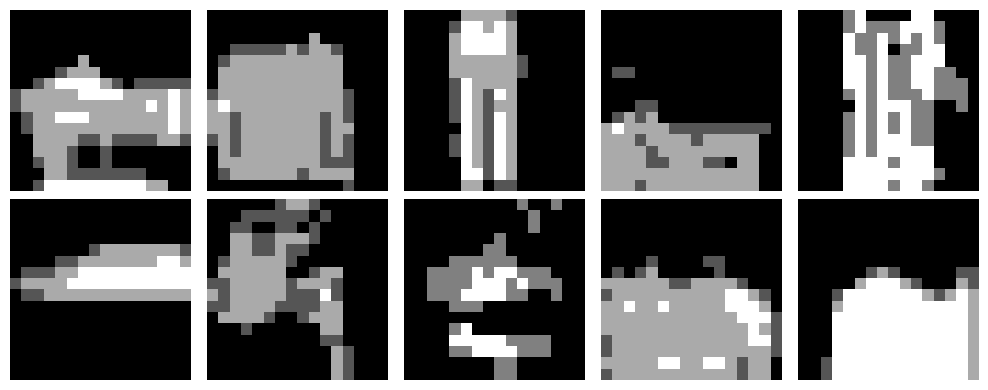

In [32]:
def plot_generated_images(images, n_cols=5):
    n_rows = (len(images) + n_cols - 1) // n_cols
    plt.figure(figsize=(2 * n_cols, 2 * n_rows))

    for idx, img in enumerate(images):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate sample images (assuming you've done this step already)
sample_images = generate_images(model, num_images=10, temperature=1.0)
# Plot generated images
plot_generated_images(sample_images)

